In [1]:
!nvidia-smi

Tue Dec 16 16:43:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   36C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Install SGLang and dependencies
!pip install "sglang[all]" pandas matplotlib pynvml -q
!pip install protobuf==5.28.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.6/103.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 148.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 137.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.0/535.

In [1]:
#Test Installation

from pynvml import nvmlInit, nvmlShutdown
import torch

nvmlInit()
nvmlShutdown()
print("NVML ok")

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

/tmp/ipython-input-2087078918.py:3: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import nvmlInit, nvmlShutdown


NVML ok
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [2]:
# Start SGLang Server (Background Process with Logging)

import subprocess
import time
import requests
import os

MODEL = "Qwen/Qwen2.5-0.5B-Instruct"
PORT = 30000

# Kill any existing server
!pkill -9 -f "python.*sglang"
time.sleep(2)

# Create log file
log_file = "/tmp/sglang_server.log"

print(f"Starting SGLang server on port {PORT}...")
print(f"Logs will be written to: {log_file}\n")

# Start server with output redirected to file
with open(log_file, 'w') as log:
    server_process = subprocess.Popen(
        [
            "python", "-m", "sglang.launch_server",
            "--model-path", MODEL,
            "--port", str(PORT),
            "--host", "0.0.0.0",
            "--mem-fraction-static", "0.8",
        ],
        stdout=log,
        stderr=subprocess.STDOUT,
        preexec_fn=os.setpgrp  # Create new process group
    )

print(f"Server PID: {server_process.pid}")

# Wait for server with progress and log monitoring
max_wait = 180  # 3 minutes
start = time.time()
last_log_size = 0

while time.time() - start < max_wait:
    # Check if server is responding
    try:
        resp = requests.get(f"http://127.0.0.1:{PORT}/health", timeout=1)
        if resp.status_code == 200:
            print(f"\n{'='*80}")
            print(f"✓✓✓ Server is READY after {int(time.time() - start)} seconds!")
            print(f"{'='*80}\n")
            break
    except:
        pass

    # Show log tail every 10 seconds
    elapsed = int(time.time() - start)
    if elapsed % 10 == 0 and elapsed > 0:
        try:
            current_size = os.path.getsize(log_file)
            if current_size > last_log_size:
                print(f"\n--- Log tail at {elapsed}s ---")
                !tail -5 {log_file}
                last_log_size = current_size
        except:
            pass
        print(f"Still waiting... ({elapsed}s elapsed)")

    time.sleep(2)
else:
    print(f"\n{'='*80}")
    print("✗ Server startup timeout after 3 minutes")
    print("Showing last 20 lines of logs:")
    print("="*80)
    !tail -20 {log_file}
    raise RuntimeError("SGLang server failed to start")

Starting SGLang server on port 30000...
Logs will be written to: /tmp/sglang_server.log

Server PID: 2284

--- Log tail at 10s ---
W0000 00:00:1765903771.377937    2284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765903771.377939    2284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765903771.377942    2284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2025-12-16 16:49:31.382861: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Still waitin

In [3]:
# Benchmark Functions with OpenAI Client

import time
import pandas as pd
from openai import OpenAI

# Create OpenAI client pointing to SGLang
client = OpenAI(
    base_url=f"http://127.0.0.1:{PORT}/v1",
    api_key="EMPTY"  # SGLang doesn't require real API key
)

def make_prompts(workload: str, n: int):
    if workload == "short":
        base = "What is a virtual machine? "
    elif workload == "medium":
        base = "Explain the three parallelisms: data parallelism, pipeline parallelism, and model parallelism, and discuss when to use them."
    elif workload == "long":
        base = ("Write a paper to discuss confidential computing. Make sure to discuss the four security primitives: confidentiality, integrity, attestation, and hardware root of trust, and provide examples to explain each of them."
        )
    else:
        raise ValueError("workload must be short|medium|long")
    return [base for _ in range(n)]

def run_once_sglang(prompts, max_new_tokens=128, temperature=0.0):
    """Run inference using SGLang via OpenAI-compatible API."""
    t0 = time.perf_counter()

    # Send requests (SGLang will batch them internally)
    responses = []
    for prompt in prompts:
        response = client.completions.create(
            model=MODEL,
            prompt=prompt,
            max_tokens=max_new_tokens,
            temperature=temperature,
        )
        responses.append(response)

    t1 = time.perf_counter()

    # Count output tokens
    out_tokens = sum(r.usage.completion_tokens for r in responses)

    return (t1 - t0), out_tokens

In [4]:
# GPU Monitoring

import threading
import statistics
from pynvml import (
    nvmlInit, nvmlShutdown, nvmlDeviceGetHandleByIndex,
    nvmlDeviceGetUtilizationRates, nvmlDeviceGetMemoryInfo
)

class GpuSampler:
    def __init__(self, device_index=0, interval_s=0.2):
        self.device_index = device_index
        self.interval_s = interval_s
        self._stop = threading.Event()
        self.util = []
        self.mem_mb = []
        self._thr = None
        self._handle = None

    def start(self):
        nvmlInit()
        self._handle = nvmlDeviceGetHandleByIndex(self.device_index)

        def loop():
            while not self._stop.is_set():
                try:
                    u = nvmlDeviceGetUtilizationRates(self._handle).gpu
                    m = nvmlDeviceGetMemoryInfo(self._handle).used / (1024**2)
                    self.util.append(u)
                    self.mem_mb.append(m)
                except:
                    pass
                time.sleep(self.interval_s)

        self._thr = threading.Thread(target=loop, daemon=True)
        self._thr.start()

    def stop(self):
        self._stop.set()
        if self._thr:
            self._thr.join(timeout=2.0)
        try:
            nvmlShutdown()
        except:
            pass

    def summary(self):
        def safe_stats(xs):
            if not xs: return (None, None, None)
            return (statistics.mean(xs), max(xs), min(xs))
        util_mean, util_max, util_min = safe_stats(self.util)
        mem_mean, mem_max, mem_min = safe_stats(self.mem_mb)
        return {
            "gpu_util_mean_%": util_mean,
            "gpu_util_max_%": util_max,
            "mem_used_mean_mb": mem_mean,
            "mem_used_max_mb": mem_max,
        }

In [5]:
# Run Benchmark

workloads = ["short", "medium", "long"]
batch_sizes = [1, 2, 4, 8, 16]
max_new_tokens_list = [32, 64, 128, 256]

rows = []

# Warmup (keep small)
print("Warming up...")
_ = run_once_sglang(make_prompts("short", 2), max_new_tokens=32)
print("✓ Warmup complete\n")

print("Running benchmark...")
print("=" * 80)

for max_new_tokens in max_new_tokens_list:
    print(f"\n>>> max_new_tokens = {max_new_tokens}")
    print("-" * 80)

    for w in workloads:
        for b in batch_sizes:
            print(
                f"  workload={w:6s}, batch_size={b:2d}",
                end="",
                flush=True
            )

            prompts = make_prompts(w, b)

            sampler = GpuSampler(interval_s=0.2)
            sampler.start()

            dt, out_toks = run_once_sglang(
                prompts,
                max_new_tokens=max_new_tokens
            )

            sampler.stop()
            g = sampler.summary()

            print(
                f" → {dt:.2f}s, {out_toks} tokens, "
                f"{out_toks / dt:.1f} tok/s"
            )

            rows.append({
                "workload": w,
                "batch_size": b,
                "max_new_tokens": max_new_tokens,
                "latency_s_per_batch": dt,
                "out_tokens_total": out_toks,
                "tokens_per_s": (out_toks / dt) if dt > 0 else float("nan"),
                "latency_s_per_request": dt / b,
                **g
            })

df = pd.DataFrame(rows)

print("\n" + "=" * 80)
print("RESULTS")
print("=" * 80)
display(df)

Warming up...
✓ Warmup complete

Running benchmark...

>>> max_new_tokens = 32
--------------------------------------------------------------------------------
  workload=short , batch_size= 1 → 0.09s, 32 tokens, 359.9 tok/s
  workload=short , batch_size= 2 → 0.16s, 64 tokens, 401.1 tok/s
  workload=short , batch_size= 4 → 0.32s, 128 tokens, 405.4 tok/s
  workload=short , batch_size= 8 → 0.63s, 256 tokens, 404.2 tok/s
  workload=short , batch_size=16 → 1.27s, 512 tokens, 403.4 tok/s
  workload=medium, batch_size= 1 → 0.08s, 32 tokens, 405.1 tok/s
  workload=medium, batch_size= 2 → 0.16s, 64 tokens, 399.6 tok/s
  workload=medium, batch_size= 4 → 0.32s, 128 tokens, 400.8 tok/s
  workload=medium, batch_size= 8 → 0.64s, 256 tokens, 401.5 tok/s
  workload=medium, batch_size=16 → 1.28s, 512 tokens, 398.5 tok/s
  workload=long  , batch_size= 1 → 0.08s, 32 tokens, 401.4 tok/s
  workload=long  , batch_size= 2 → 0.16s, 64 tokens, 398.7 tok/s
  workload=long  , batch_size= 4 → 0.33s, 128 tokens, 

,workload,batch_size,max_new_tokens,latency_s_per_batch,out_tokens_total,tokens_per_s,latency_s_per_request,gpu_util_mean_%,gpu_util_max_%,mem_used_mean_mb,mem_used_max_mb
0,short,1,32,0.088902,32,359.948037,0.088902,4.000000,4,67934.125,67934.125
1,short,2,32,0.159542,64,401.147211,0.079771,61.000000,61,67934.125,67934.125
2,short,4,32,0.315734,128,405.404861,0.078933,52.000000,57,67934.125,67934.125
3,short,8,32,0.633303,256,404.229744,0.079163,64.000000,76,67934.125,67934.125
4,short,16,32,1.269077,512,403.442791,0.079317,62.285714,77,67934.125,67934.125
5,medium,1,32,0.079003,32,405.050176,0.079003,53.000000,53,67934.125,67934.125
6,medium,2,32,0.160175,64,399.562778,0.080088,28.000000,28,67934.125,67934.125
7,medium,4,32,0.319333,128,400.835153,0.079833,49.500000,56,67934.125,67934.125
8,medium,8,32,0.637576,256,401.520484,0.079697,63.750000,72,67934.125,67934.125
9,medium,16,32,1.284753,512,398.520111,0.080297,62.428571,75,67934.125,67934.125


In [6]:
df.to_csv("SGlang_benchmark_results.csv", index=False)
from google.colab import files
files.download("/content/SGlang_benchmark_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

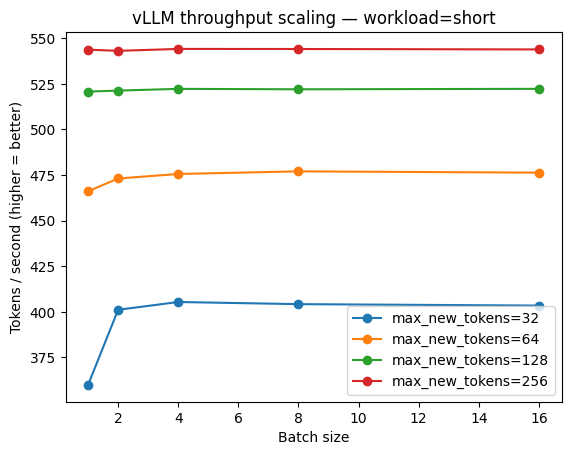

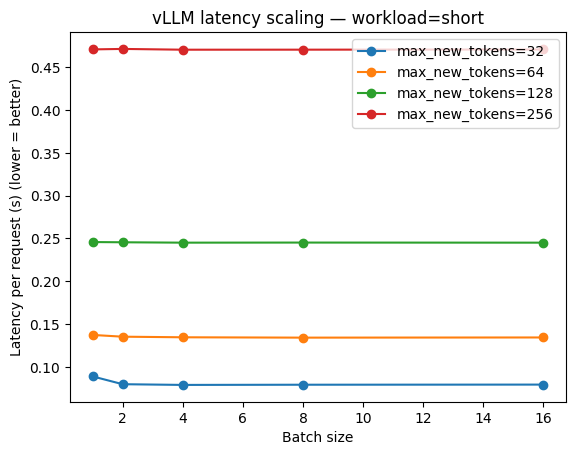

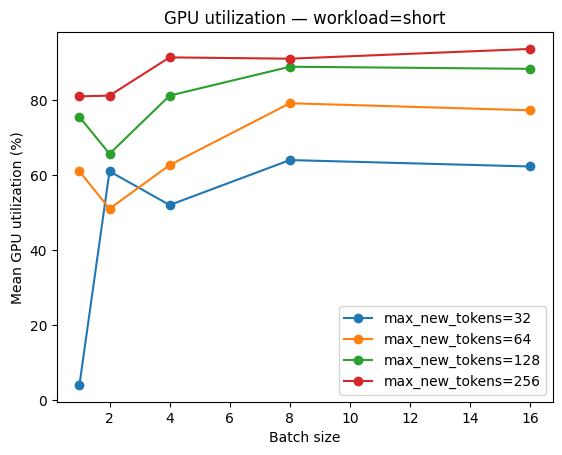

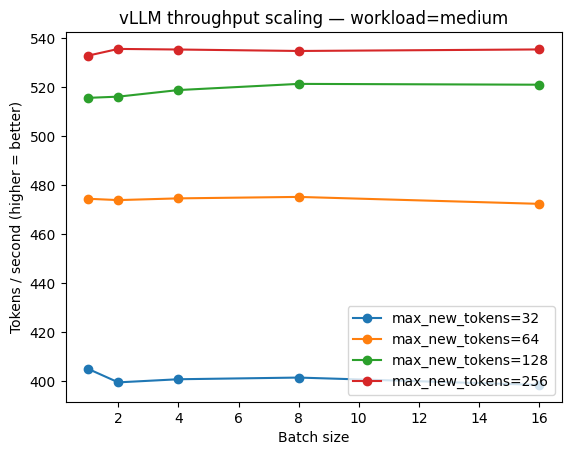

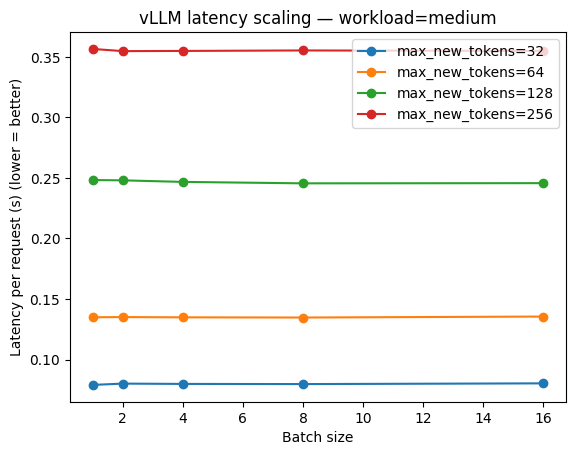

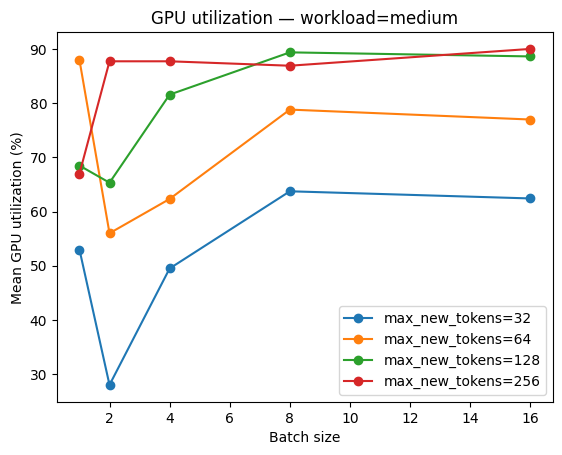

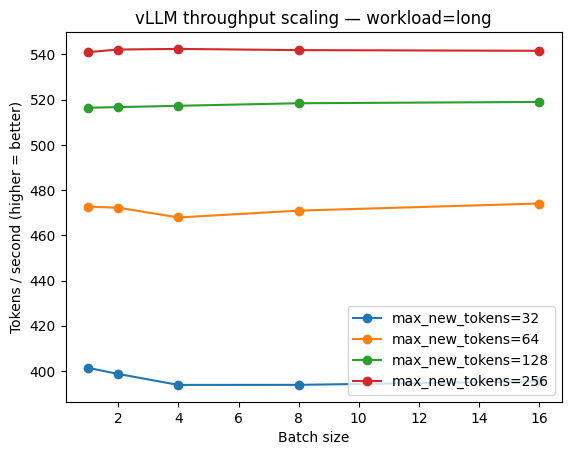

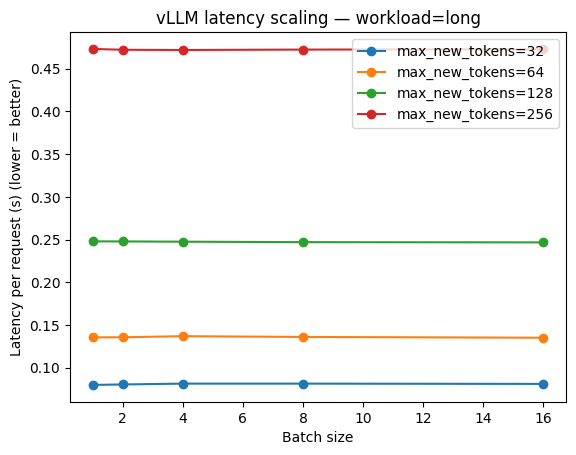

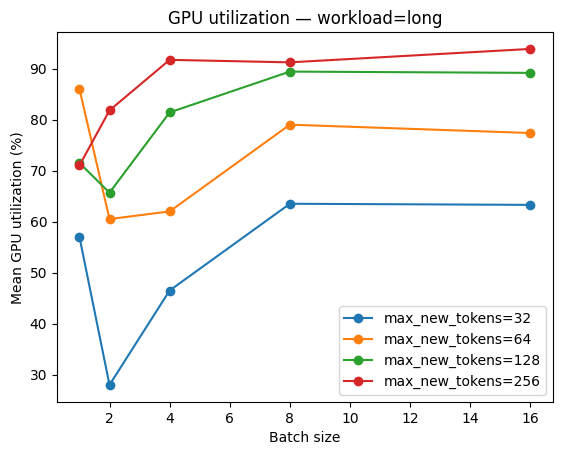

In [7]:
import matplotlib.pyplot as plt

max_new_tokens_list = sorted(df["max_new_tokens"].unique())

for w in workloads:
    # Throughput overlay
    plt.figure()
    for m in max_new_tokens_list:
        sub = df[(df["workload"] == w) & (df["max_new_tokens"] == m)].sort_values("batch_size")
        plt.plot(sub["batch_size"], sub["tokens_per_s"], marker="o", label=f"max_new_tokens={m}")
    plt.xlabel("Batch size")
    plt.ylabel("Tokens / second (higher = better)")
    plt.title(f"vLLM throughput scaling — workload={w}")
    plt.legend()
    plt.show()

    # Latency overlay
    plt.figure()
    for m in max_new_tokens_list:
        sub = df[(df["workload"] == w) & (df["max_new_tokens"] == m)].sort_values("batch_size")
        plt.plot(sub["batch_size"], sub["latency_s_per_request"], marker="o", label=f"max_new_tokens={m}")
    plt.xlabel("Batch size")
    plt.ylabel("Latency per request (s) (lower = better)")
    plt.title(f"vLLM latency scaling — workload={w}")
    plt.legend()
    plt.show()

    # GPU util overlay
    plt.figure()
    for m in max_new_tokens_list:
        sub = df[(df["workload"] == w) & (df["max_new_tokens"] == m)].sort_values("batch_size")
        plt.plot(sub["batch_size"], sub["gpu_util_mean_%"], marker="o", label=f"max_new_tokens={m}")
    plt.xlabel("Batch size")
    plt.ylabel("Mean GPU utilization (%)")
    plt.title(f"GPU utilization — workload={w}")
    plt.legend()
    plt.show()